## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [2]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
from sklearn.decomposition import PCA
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# fixing all random parameters
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic=True

In [4]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3),
                                   nn.BatchNorm2d(16),
                                   nn.LeakyReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3),
                                   nn.BatchNorm2d(32),
                                   nn.LeakyReLU())
        
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(2))
        
        self.conv4 = nn.Sequential(nn.Conv2d(64, 16, 3),
                                   nn.BatchNorm2d(16),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(2))

        self.conv5 = nn.Sequential(nn.Conv2d(16, 10, 3),
                                   nn.BatchNorm2d(10),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        output = F.max_pool2d(x, kernel_size=x.size()[2:])
        return output

In [5]:
def train(epoch_num, model, optimizer, loss_func, train_loader):
    model.train()
    acc_history=[]
    loss_history=[]
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        
        x, y = Variable(x), Variable(y)
        optimizer.zero_grad()
        
        y_ = model(x)
        y_ = y_.squeeze(3)
        y_ = y_.squeeze(2)

        loss = loss_func(y_, y)
        loss.backward()
        optimizer.step()
        
        pred = y_.data.max(1)[1]
        correct = pred.eq(y.data).cpu().sum()

        acc = float(correct) / len(pred)
        
        if batch_idx % 100 == 0:
            acc_history.append(acc)
            loss_history.append(loss.item())
#             print(f'Train Epoch: {epoch_num+1} [{ batch_idx * len(x)}/{len(train_loader.dataset)}'
#                   f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: { loss.item():.6f} acc={acc:.3f}')
    return acc_history, loss_history

In [6]:
def test(epoch_num, model, loss_func, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            y_ = model(x)
            y_ = y_.squeeze(3)
            y_ = y_.squeeze(2)

            test_loss += loss_func(y_, y).item()
            pred = y_.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(y.data).cpu().sum()

        acc = 100. * float(correct) / len(test_loader.dataset)

        test_loss /= len(test_loader.dataset)
        print(
            f'epoch {epoch_num} test set: '
            f'Average loss: {test_loss:.4f}, '
            f'Accuracy: {correct}/{ len(test_loader.dataset)}'
            f' ({acc:.0f}%)')


epoch 25 test set: Average loss: 0.0054, Accuracy: 8791/10000 (88%)


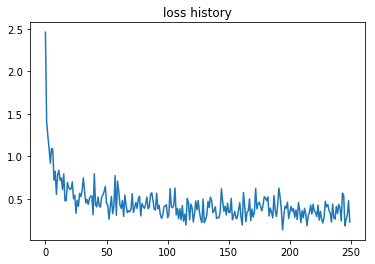

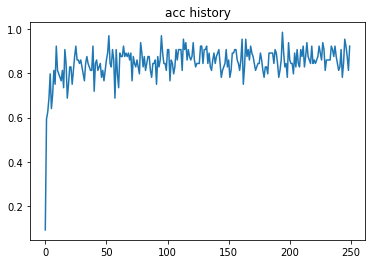

In [8]:
def main():
    n_epoches = 25
    model = MyModel().to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    train_loader = DataLoader(
        datasets.FashionMNIST(root=".", train=True, download=True, transform=transforms.Compose([

            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(20),
            transforms.RandomCrop(26),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=64, shuffle=True, num_workers=4)

    test_loader = DataLoader(
        datasets.FashionMNIST(root='.', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])),
        batch_size=64, shuffle=True, num_workers=4)

    acc_history_global, loss_history_global = [], []

    for i_epoch in range(n_epoches):
        acc_history, loss_history = train(i_epoch, model, optimizer, loss_func, train_loader)
        acc_history_global += acc_history
        loss_history_global += loss_history

    test(n_epoches, model, loss_func, test_loader)
    plt.title("loss history")
    plt.plot([i for i in range(len(loss_history_global))], loss_history_global)
    plt.show()
    plt.title("acc history")
    plt.plot([i for i in range(len(acc_history_global))], acc_history_global)


if __name__ == "__main__":
    main()

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


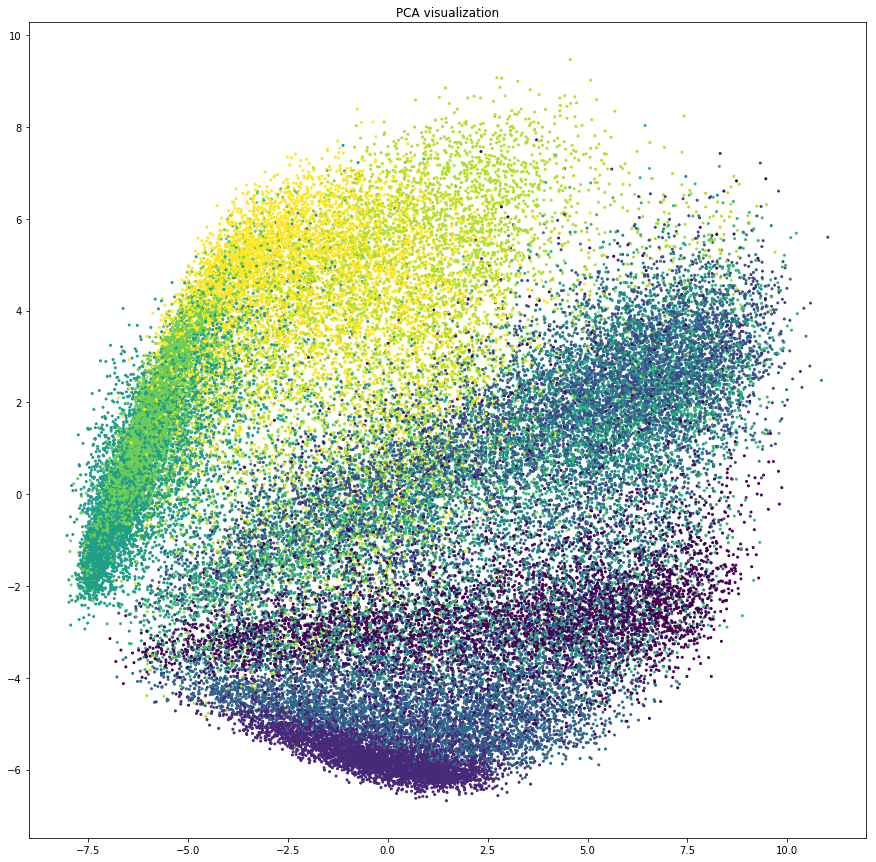

In [10]:
def visualize_pca(n_components):
    data = input_data.read_data_sets('data/fashion',
                                     source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')
    pca = PCA(n_components=n_components)
    X_pca_new = pca.fit_transform(data.train.images)

    plt.figure(figsize=(15, 15))
    plt.title("PCA visualization")
    plt.scatter(X_pca_new[:, 0], X_pca_new[:, 1], c=data.train.labels, s=4)


visualize_pca(2)
